In [1]:
using ClusteringToMATo
using Plots

In [2]:
function noisy_circle(n; r1=1, r2=1, noise=0.1)
    points = zeros(2, n)
    for i in 1:n
        θ = 2π * rand()
        point = (
            r1 * sin(θ) + noise * rand() - noise / 2,
            r2 * cos(θ) + noise * rand() - noise / 2,
        )
        points[:,i] .= point
    end
    return points
end

noisy_circle (generic function with 1 method)

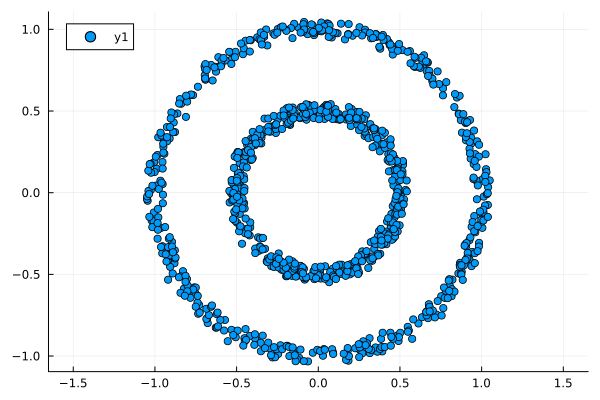

In [3]:
points = hcat(noisy_circle(500), noisy_circle(500, r1=0.5, r2=0.5))
scatter(points[1,:], points[2,:], aspect_ratio=1)

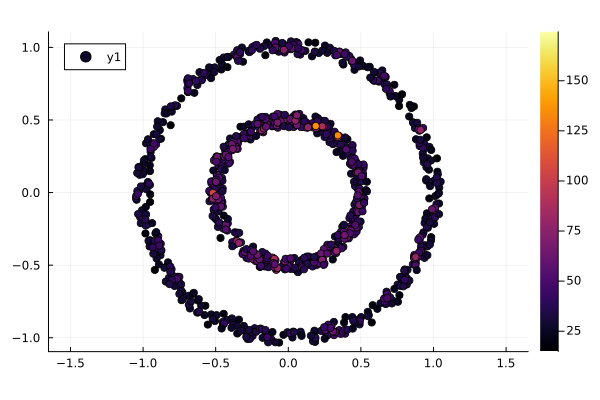

In [40]:
import ClusteringToMATo: BallGraph, compute_graph, compute_density, DTM
graph = compute_graph(BallGraph(0.1), points)
f = compute_density(DTM(5), points)
scatter(points[1,:], points[2,:], marker_z = f, aspect_ratio=1)

In [41]:
import ClusteringToMATo: compute_persistence

In [42]:
labels, intervals = compute_persistence(points, f, graph, Inf)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Dict(684 => (41.122251560824814, 44.10930314620233), 711 => (45.01840525003167, 65.76938899082452), 501 => (40.97839852635929, Inf), 723 => (34.93442687894466, 51.406203981917315), 699 => (79.33478208978288, 93.12365805593765), 6 => (133.4272724835665, Inf), 45 => (77.6627009459063, Inf), 320 => (49.50908798588744, Inf), 342 => (48.11268992617615, Inf), 817 => (37.723299640046854, 77.6627009459063)…))

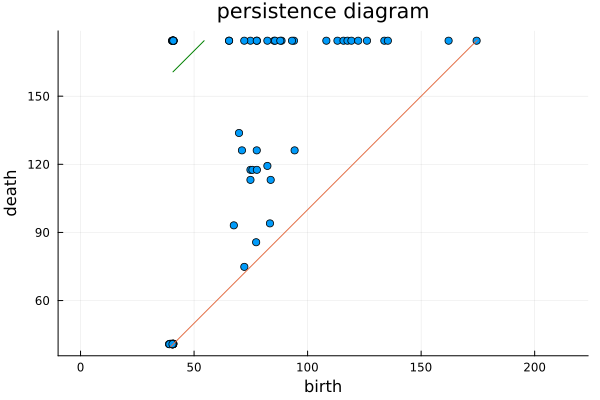

In [49]:

plot(intervals, τ = 120)

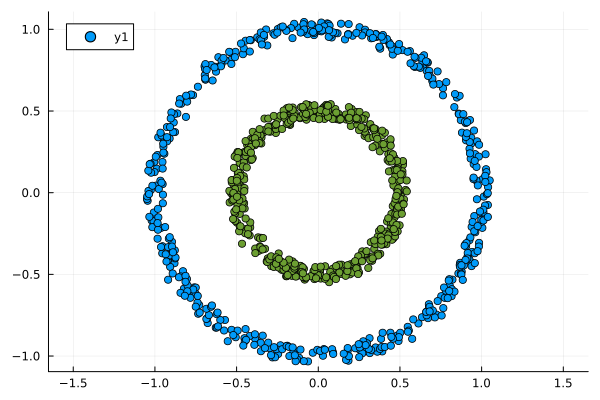

In [51]:
labels, intervals = compute_persistence(points, f, graph, 120)
scatter(points[1,:], points[2,:], c = labels, aspect_ratio=1)